In [141]:
%load_ext autoreload
%autoreload 2


import numpy as np
import networkx as nx
import logging, sys
import cstrees.scoring as sc
import cstrees.cstree as ct

import matplotlib.pyplot as plt

logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)

# CStree from Figure 1 in (Duarte & Solus, 2022)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0 []
1 [<cstrees.cstree.Stage object at 0x7fb8d6f78430>]
2 [<cstrees.cstree.Stage object at 0x7fb8c7c0b400>, <cstrees.cstree.Stage object at 0x7fb8c7c0b280>, <cstrees.cstree.Stage object at 0x7fb8c7c0b610>]
3 []
[[1 0 0 0]
 [0 0 1 1]
 [1 0 1 0]
 [0 1 1 0]
 [1 1 0 1]]
level 0 in the tree scoring procedure
pred_vals: []
singleton stage
None
pred_vals: []
singleton stage
None
pred_vals: []
singleton stage
None
pred_vals: []
singleton stage
None
pred_vals: []
singleton stage
None
None: {1: 3, 0: 2}
level 1 in the tree scoring procedure
pred_vals: [1]
singleton stage
None
pred_vals: [0]
singleton stage
None
pred_vals: [1]
singleton stage
None
pred_vals: [0]
singleton stage
None
pred_vals: [1]
singleton stage
None
None: {0: 3, 1: 2}
level 2 in the tree scoring procedure
pred_vals: [1 0]
pred_vals: [0 0]
pred_vals: [1 0]
pred_vals: [0 1]
singleton stage
None
pred_vals: [1 1]
singleton stage
None
[{0, 1}, 0]: {0: 1, 1: 2}
None: {1: 1, 0: 1}
level 3 in the tree scoring procedure
pred_vals: [1 0

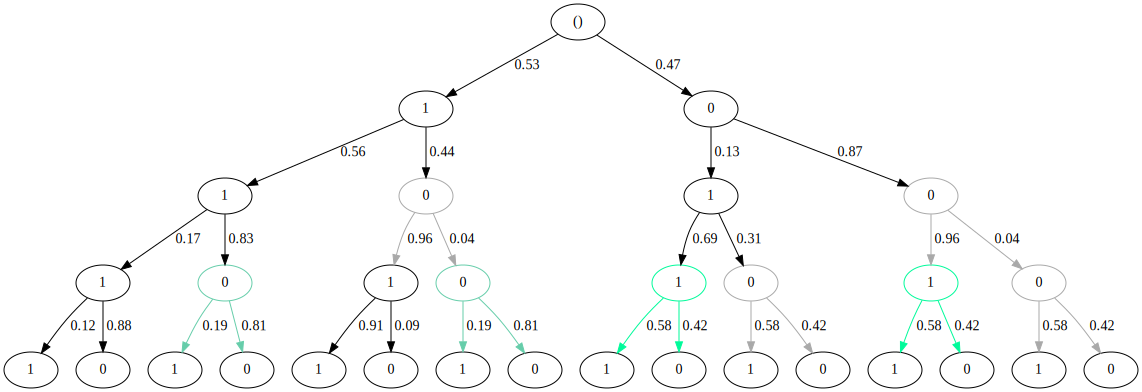

In [142]:
np.random.seed(2)
p=4
cards = [2] * p
co = ct.CausalOrder(range(p))
tree = ct.CStree(co)


#stage = ct.sample_random_stage(cards,2)
#stage.set_random_params(cards)

tree.set_cardinalities(cards)

# These do not have to be in a dict like this as the levels are
# determined from the length of the tuples.

tree.set_stages({
    0: [],
    1: [ct.Stage([{0, 1}, 0])],    # Green
    2: [ct.Stage([0, {0, 1}, 0]),  # Blue
        ct.Stage([0, {0, 1}, 1]),  # Orange
        ct.Stage([1, {0, 1}, 0])]  # Red
})


tree.set_random_stage_parameters()


a = tree.plot()
a.draw("testplot.png")
x = tree.sample(5)

#x = tree.sample(5)
print(x)

s = sc.score(tree, x, alpha_tot=1.0, method="K2")
print(s)
#rels = tree.csi_relations()

#print("Initial rels")
#print(rels)
adjmats = tree.to_minimal_context_graphs()

for key, graph in adjmats.items():
    agraph = nx.nx_agraph.to_agraph(graph)
    agraph.layout("dot")
    agraph.draw(str(key) + "_csi.png", args='-Glabel="'+str(key)+'"   ')
a

In [ ]:
tree.to_df()

[2, 2, 2, 2]
full_stage_space_size: 2
level: 0, mc: 1, minimal_stage_size: 1
full_stage_space_size: 4
level: 1, mc: 1, minimal_stage_size: 2
full_stage_space_size: 8
level: 2, mc: 1, minimal_stage_size: 4
0 [<cstrees.cstree.Stage object at 0x7fb8b5ba2c10>]
1 [<cstrees.cstree.Stage object at 0x7fb8b5ba2460>, <cstrees.cstree.Stage object at 0x7fb8b5ba22b0>]
2 [<cstrees.cstree.Stage object at 0x7fb8b5ba2b50>]
3 []


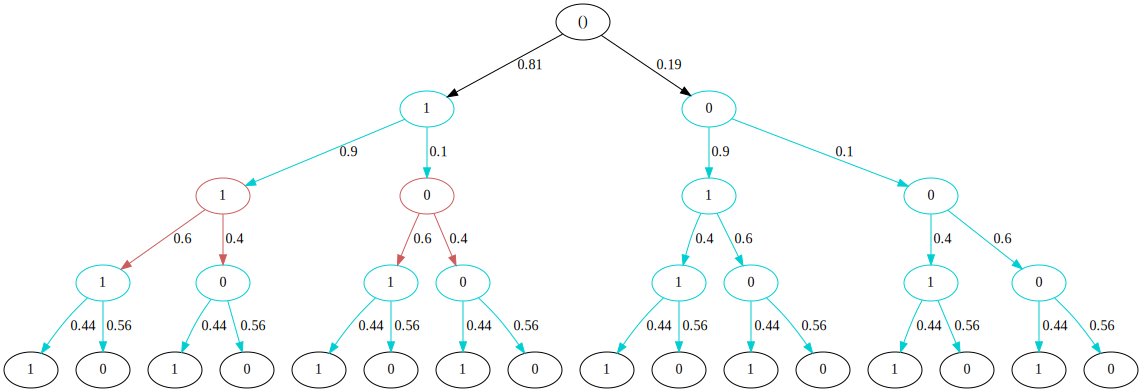

In [143]:

print(cards)
np.random.seed(2)
t = ct.sample_cstree(cards, max_cvars=1, prob_cvar=0.5, prop_nonsingleton=1)
t.set_random_stage_parameters()
a = t.plot()
x = t.sample(1000)

#plt.savefig("testplot.png")
a



In [144]:

order = [0, 1, 2, 3]
level = 2
score = sc.score_order(order, cards, x, max_cvars=1, alpha_tot=1.0, method="BDeu")
print(score)
 

level 0
stagings at level -1:
stages: [<cstrees.cstree.Stage object at 0x7fb8b7d75f70>]
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pr

In [145]:
stagings = ct.all_stagings(order, cards, level, max_cvars=1)
print("#Stagings")
nst = ct.n_stagings(order, cards, level, max_cvars=1)
print(nst)
print("Stagings")
for ss in stagings:
    for s in ss:
        print(s)

#Stagings
7
Stagings
[0, {0, 1}, {0, 1}]
[1, {0, 1}, {0, 1}]
[{0, 1}, 0, {0, 1}]
[{0, 1}, 1, {0, 1}]
[{0, 1}, {0, 1}, 0]
[{0, 1}, {0, 1}, 1]
[{0, 1}, {0, 1}, {0, 1}]


In [146]:
for l in range(len(order)):
    max_staging, max_score = ct.optimal_staging_at_level(order, cards, x, l, max_cvars=1, alpha_tot=1.0, method="BDeu")
    print("best staging at level {}".format(l))
    print(max_score)   
    for st in max_staging:
        print(st)

    

pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_v

pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_vals: []
pred_v

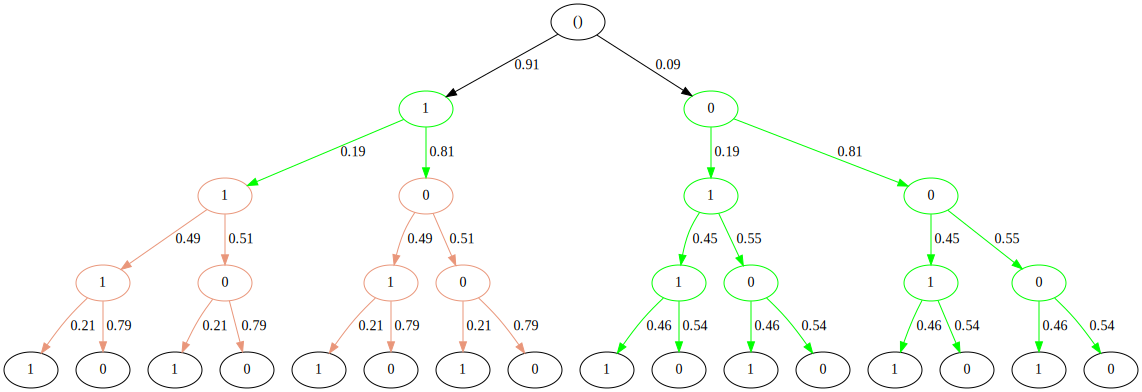

In [147]:
opttree = ct.optimal_cstree(order, cards, x, max_cvars=1, alpha_tot=1.0, method="BDeu")

opttree.set_random_stage_parameters()
opttree.plot()